# Testing FFNN on classification problems

In [48]:
from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm

from activation_functions import *
from cost_functions import *
from FFNN import *

# Setting the random seed
np.random.seed(42)


In [49]:

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
# Extract data (features) and target (labels)
X = mnist.data
y = mnist.target

# Scaling the mnist pixel values from 0-255 to 0-1
X = X / 255.0

In [50]:
# Load the digits dataset (simplified MNIST)
digits = load_digits()
X = digits.data
y = digits.target

In [51]:
print(X[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


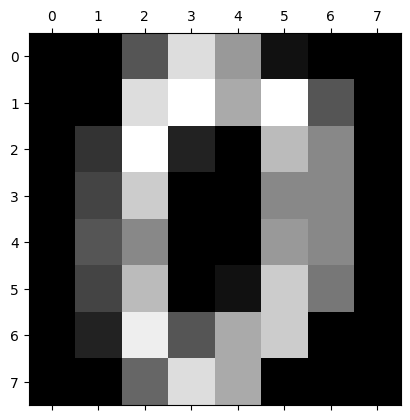

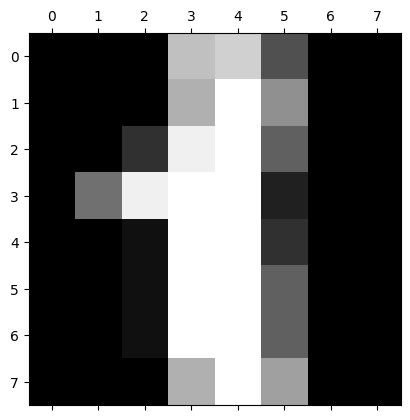

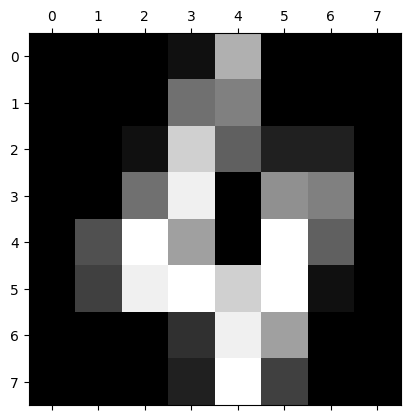

In [52]:
# Sample images from the digits dataset
plt.matshow(digits.images[0], cmap="gray")
plt.matshow(digits.images[1], cmap="gray")
plt.matshow(digits.images[4], cmap="gray")

In [53]:
# Scaling the pixel values from 0-16 to 0-1
X = X / 16.0

print(X[0])

[0.     0.     0.3125 0.8125 0.5625 0.0625 0.     0.     0.     0.
 0.8125 0.9375 0.625  0.9375 0.3125 0.     0.     0.1875 0.9375 0.125
 0.     0.6875 0.5    0.     0.     0.25   0.75   0.     0.     0.5
 0.5    0.     0.     0.3125 0.5    0.     0.     0.5625 0.5    0.
 0.     0.25   0.6875 0.     0.0625 0.75   0.4375 0.     0.     0.125
 0.875  0.3125 0.625  0.75   0.     0.     0.     0.     0.375  0.8125
 0.625  0.     0.     0.    ]


In [54]:
# Splitting the data into testing an training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Convert labels to integers first (MNIST labels are strings)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [56]:
# Convert to one-hot encoding [0, 1, 2, ..., 9] with 10 classes
def to_one_hot(y, num_classes=10):
    """Convert integer labels to one-hot encoding"""
    n_samples = y.shape[0]
    one_hot = np.zeros((n_samples, num_classes))
    one_hot[np.arange(n_samples), y] = 1
    return one_hot

y_train_onehot = to_one_hot(y_train)
y_test_onehot = to_one_hot(y_test)

# Testing learning rates

In [57]:
network_input_size = X_train.shape[1]
layer_output_sizes = [100, 50, 10]
activation_funcs = [sigmoid, ReLU, softmax]

In [58]:
# Create initial network and save the initial layers
NN_initial = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)
initial_layers = deepcopy(NN_initial.layers)

In [59]:
epochs = 25

accs = []

etas = np.logspace(1, -4, num=6)

for eta in etas:
    NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)
    NN.layers = deepcopy(initial_layers)

    train_network_stocastic_ADAM(NN, X_train, y_train_onehot, eta=eta, epochs=epochs)

    y_pred = NN.predict(X_train)

    acc = accuracy(y_pred, y_train_onehot)

    accs.append(acc)

c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: invalid value encountered in multiply


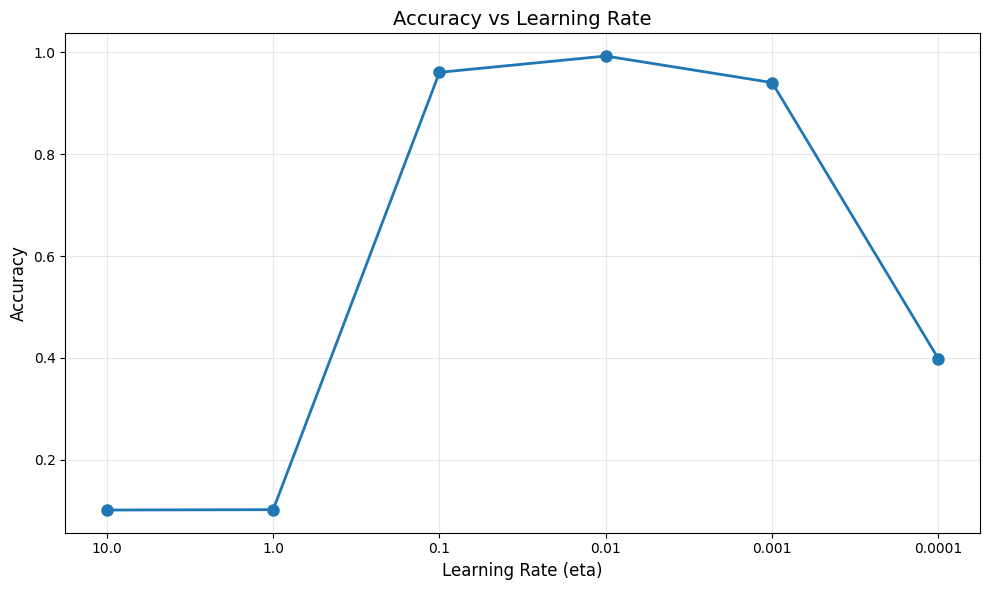

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(etas)), accs, marker='o', linewidth=2, markersize=8)
plt.xticks(range(len(etas)), etas)  # Label x-axis with eta values
plt.xlabel('Learning Rate (eta)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs Learning Rate', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Testing parameter combinations with grid search

In [69]:
# Splitting the data into testing an training sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

# One-hot encoding
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)
y_val = to_one_hot(y_val)

In [ ]:
# Define parameters
layer_sizes = [5, 10, 25, 50]
num_hidden_layers = [0, 1]
etas = np.logspace(-1, -2, num=2)
activation_functions = [sigmoid, ReLU, leaky_ReLU]
epochs = [10, 25, 50, 100]
optimizers = [train_network_SRMSprop, train_network_stocastic_ADAM]
cost_functions = [cross_entropy, cross_entropy_L1, cross_entropy_L2]

network_input_size = X_train.shape[1]

In [ ]:

total_combinations = len(list(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers)))

# Store results
results = []

for _, (num_layers, num_nodes, eta, act_func, num_epochs, optimizer, cost_func) in enumerate(tqdm(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers, cost_functions), total=total_combinations)):

    # If no hidden layers
    if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
    else:
        # Hidden layers + output layer
        layer_output_sizes = [num_nodes] * num_layers + [10]
        activation_funcs = [act_func] * num_layers + [softmax]

    # Create and train network
    NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

    optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

    train_pred = NN.predict(X_train)
    val_pred = NN.predict(X_val)
    
    train_accuracy = accuracy(train_pred, y_train)
    val_accuracy = accuracy(val_pred, y_val)

    # Store results
    results.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'train_acc': train_accuracy,
        'val_acc': val_accuracy
    })

 91%|█████████ | 350/384 [12:51<01:36,  2.84s/it]c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
100%|██████████| 384/384 [14:46<00:00,  2.31s/it]


In [80]:
# Evaluate results
df_results = pd.DataFrame(results)

# Save results to file
df_results.to_csv('neural_network_results2.csv', index=False)

# Find best configuration
best_idx = df_results['val_acc'].idxmax()
best_config = df_results.iloc[best_idx]

print(f"Best configuration:")
print(f"Hidden layers: {best_config['n_hidden']}")
print(f"Layer size: {best_config['layer_size']}")
print(f"Learning rate: {best_config['eta']:.6f}")
print(f"Activation: {best_config['activation']}")
print(f"Optimizer: {best_config['optimizer']}")
print(f"Epochs: {best_config['n_epochs']}")
print(f"Validation accuracy: {best_config['val_acc']:.4f}")

Best configuration:
Hidden layers: 1
Layer size: 50
Learning rate: 0.010000
Activation: sigmoid
Optimizer: train_network_stocastic_ADAM
Epochs: 50
Validation accuracy: 0.9806


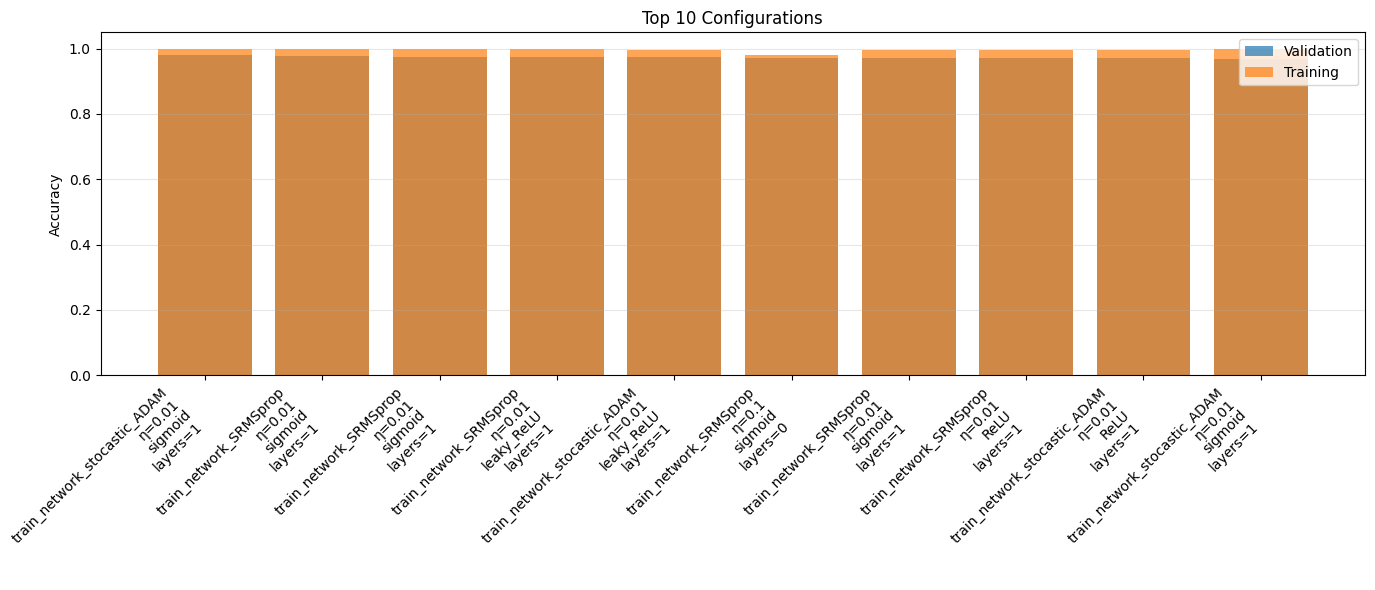

In [81]:
# Get top 10 configurations
top_10 = df_results.nlargest(10, 'val_acc').copy()
top_10['config'] = (top_10['optimizer'] + '\n' + 
                    'η=' + top_10['eta'].astype(str) + '\n' +
                    top_10['activation'] + '\n' +
                    'layers=' + top_10['n_hidden'].astype(str))

plt.figure(figsize=(14, 6))
x = range(len(top_10))
plt.bar(x, top_10['val_acc'], alpha=0.7, label='Validation')
plt.bar(x, top_10['train_acc'], alpha=0.7, label='Training')
plt.xticks(x, top_10['config'], rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Top 10 Configurations')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [82]:
print(top_10)

     n_hidden  layer_size   eta  activation  n_epochs  \
365         1          50  0.01     sigmoid        50   
364         1          50  0.01     sigmoid        50   
366         1          50  0.01     sigmoid       100   
382         1          50  0.01  leaky_ReLU       100   
383         1          50  0.01  leaky_ReLU       100   
0           0           5  0.10     sigmoid        10   
362         1          50  0.01     sigmoid        25   
372         1          50  0.01        ReLU        50   
375         1          50  0.01        ReLU       100   
317         1          25  0.01     sigmoid        50   

                        optimizer  train_acc   val_acc  \
365  train_network_stocastic_ADAM   1.000000  0.980556   
364        train_network_SRMSprop   1.000000  0.977778   
366        train_network_SRMSprop   1.000000  0.975000   
382        train_network_SRMSprop   0.999072  0.975000   
383  train_network_stocastic_ADAM   0.996289  0.975000   
0          train_network

# Testing layers and nodes

In [ ]:
network_input_size = X_train.shape[1]
layer_sizes = [10, 25, 50, 100, 200]
num_hidden_layers = [0, 1, 2, 3, 4]

Done with: 0 x 10
Done with: 0 x 25
Done with: 0 x 50
Done with: 0 x 100
Done with: 0 x 200
Done with: 1 x 10
Done with: 1 x 25
Done with: 1 x 50
Done with: 1 x 100
Done with: 1 x 200
Done with: 2 x 10
Done with: 2 x 25
Done with: 2 x 50
Done with: 2 x 100
Done with: 2 x 200
Done with: 3 x 10
Done with: 3 x 25
Done with: 3 x 50
Done with: 3 x 100
Done with: 3 x 200
Done with: 4 x 10
Done with: 4 x 25
Done with: 4 x 50
Done with: 4 x 100
Done with: 4 x 200


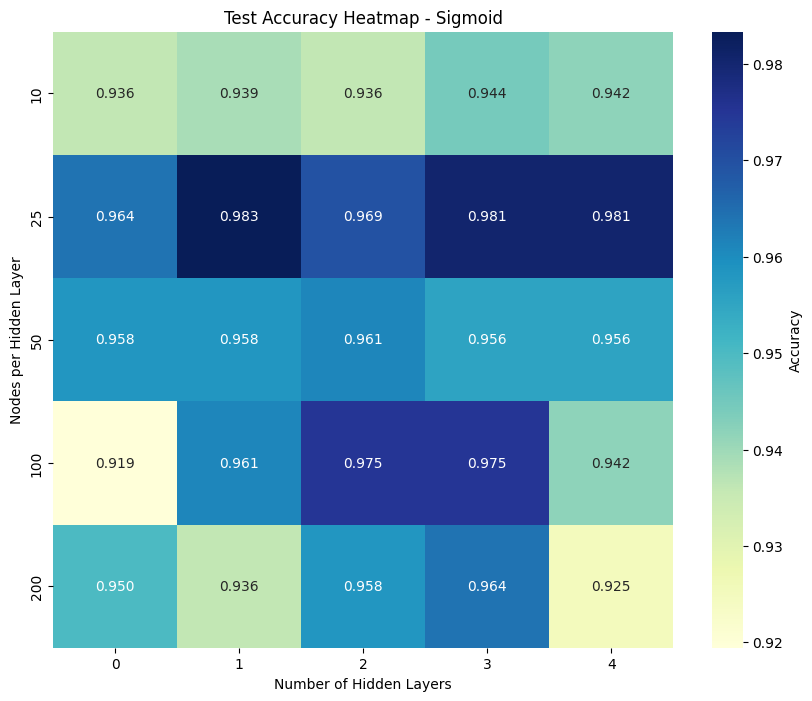

In [ ]:
# Store results in 2D array
results = np.zeros((len(num_hidden_layers), len(layer_sizes)))

for i, num_layers in enumerate(num_hidden_layers):
    for j, layer_size in enumerate(layer_sizes):

        if num_layers == 0:
            # No hidden layers - just input to output
            layer_output_sizes = [10]
            activation_funcs = [softmax]
        else:
            # Hidden layers + output layer
            layer_output_sizes = [layer_size] * num_layers + [10]
            activation_funcs = [sigmoid] * num_layers + [softmax]


        # Create and train network
        NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

        train_network_stocastic_ADAM(NN, X_train, y_train_onehot, eta=0.01, epochs=25)
        
        y_pred = NN.predict(X_test)
        acc = accuracy(y_pred, y_test_onehot)

        results[i, j] = acc

        print(f"Done with: {num_layers} x {layer_size}")


plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=num_hidden_layers,
            yticklabels=layer_sizes,
            cbar_kws={'label': 'Accuracy'})
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Nodes per Hidden Layer')
plt.title('Test Accuracy Heatmap - Sigmoid')
plt.show()

Done with: 0 x 10
Done with: 0 x 25
Done with: 0 x 50
Done with: 0 x 100
Done with: 0 x 200
Done with: 1 x 10
Done with: 1 x 25
Done with: 1 x 50
Done with: 1 x 100
Done with: 1 x 200
Done with: 2 x 10
Done with: 2 x 25
Done with: 2 x 50
Done with: 2 x 100


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)


Done with: 2 x 200
Done with: 3 x 10
Done with: 3 x 25


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: overflow encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvj

Done with: 3 x 50


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: invalid value encountered in multiply


Done with: 3 x 100


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x

Done with: 3 x 200
Done with: 4 x 10


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: invalid value encountered in multiply


Done with: 4 x 25


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:124: RuntimeWarning: overflow encountered in divide
  lambd

Done with: 4 x 50


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x

Done with: 4 x 100


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x

Done with: 4 x 200


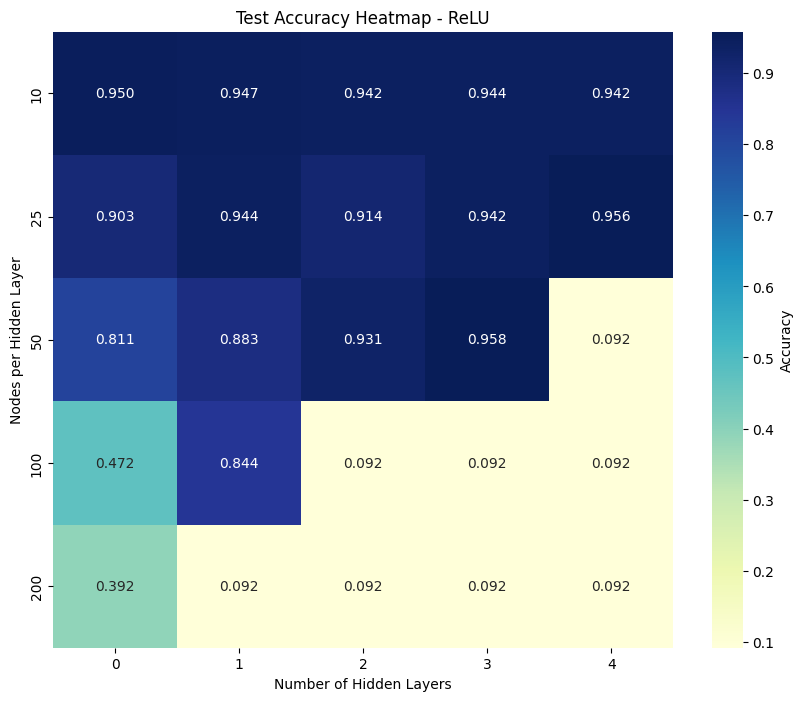

In [ ]:
# Store results in 2D array
results = np.zeros((len(num_hidden_layers), len(layer_sizes)))

for i, num_layers in enumerate(num_hidden_layers):
    for j, layer_size in enumerate(layer_sizes):

        if num_layers == 0:
            # No hidden layers - just input to output
            layer_output_sizes = [10]
            activation_funcs = [softmax]
        else:
            # Hidden layers + output layer
            layer_output_sizes = [layer_size] * num_layers + [10]
            activation_funcs = [ReLU] * num_layers + [softmax]


        # Create and train network
        NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

        train_network_stocastic_ADAM(NN, X_train, y_train_onehot, eta=0.01, epochs=25)
        
        y_pred = NN.predict(X_test)
        acc = accuracy(y_pred, y_test_onehot)

        results[i, j] = acc

        print(f"Done with: {num_layers} x {layer_size}")


plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=num_hidden_layers,
            yticklabels=layer_sizes,
            cbar_kws={'label': 'Accuracy'})
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Nodes per Hidden Layer')
plt.title('Test Accuracy Heatmap - ReLU')
plt.show()

Done with: 0 x 10
Done with: 0 x 25
Done with: 0 x 50
Done with: 0 x 100
Done with: 0 x 200
Done with: 1 x 10
Done with: 1 x 25
Done with: 1 x 50
Done with: 1 x 100
Done with: 1 x 200
Done with: 2 x 10
Done with: 2 x 25
Done with: 2 x 50


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)


Done with: 2 x 100


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: invalid value encountered in multiply


Done with: 2 x 200
Done with: 3 x 10
Done with: 3 x 25


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: invalid value encountered in multiply


Done with: 3 x 50


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: invalid value encountered in multiply


Done with: 3 x 100


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x

Done with: 3 x 200
Done with: 4 x 10


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:124: RuntimeWarning: overflow encountered in divide
  lambd

Done with: 4 x 25


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x

Done with: 4 x 50


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x

Done with: 4 x 100


c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x

Done with: 4 x 200


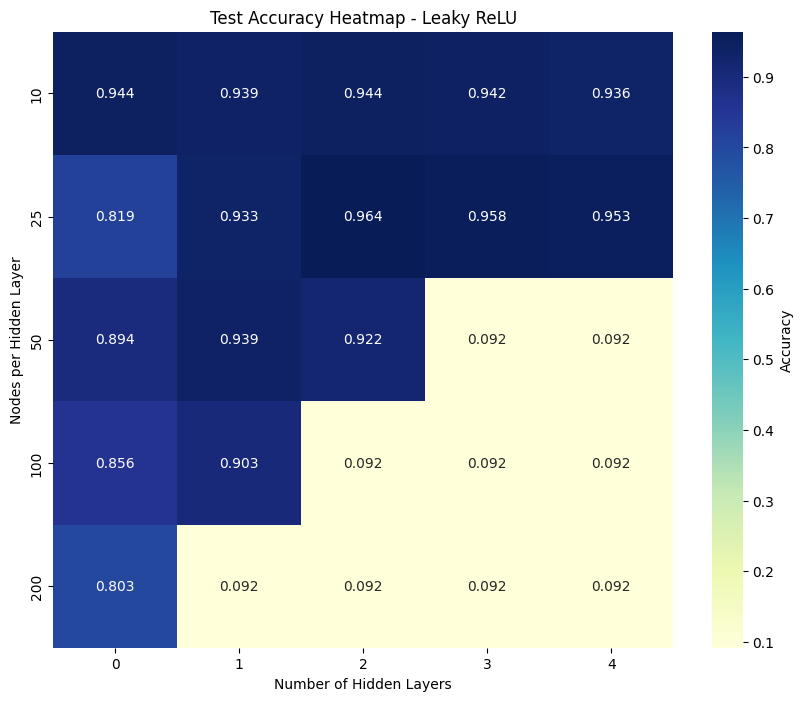

In [ ]:
# Store results in 2D array
results = np.zeros((len(num_hidden_layers), len(layer_sizes)))

for i, num_layers in enumerate(num_hidden_layers):
    for j, layer_size in enumerate(layer_sizes):

        if num_layers == 0:
            # No hidden layers - just input to output
            layer_output_sizes = [10]
            activation_funcs = [softmax]
        else:
            # Hidden layers + output layer
            layer_output_sizes = [layer_size] * num_layers + [10]
            activation_funcs = [leaky_ReLU] * num_layers + [softmax]


        # Create and train network
        NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

        train_network_stocastic_ADAM(NN, X_train, y_train_onehot, eta=0.01, epochs=25)
        
        y_pred = NN.predict(X_test)
        acc = accuracy(y_pred, y_test_onehot)

        results[i, j] = acc

        print(f"Done with: {num_layers} x {layer_size}")

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=num_hidden_layers,
            yticklabels=layer_sizes,
            cbar_kws={'label': 'Accuracy'})
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Nodes per Hidden Layer')
plt.title('Test Accuracy Heatmap - Leaky ReLU')
plt.show()

Done with: 0 x 10
Done with: 0 x 25
Done with: 0 x 50
Done with: 0 x 100
Done with: 0 x 200
Done with: 1 x 10
Done with: 1 x 25
Done with: 1 x 50
Done with: 1 x 100
Done with: 1 x 200
Done with: 2 x 10
Done with: 2 x 25
Done with: 2 x 50
Done with: 2 x 100
Done with: 2 x 200
Done with: 3 x 10
Done with: 3 x 25
Done with: 3 x 50
Done with: 3 x 100
Done with: 3 x 200
Done with: 4 x 10
Done with: 4 x 25
Done with: 4 x 50
Done with: 4 x 100
Done with: 4 x 200


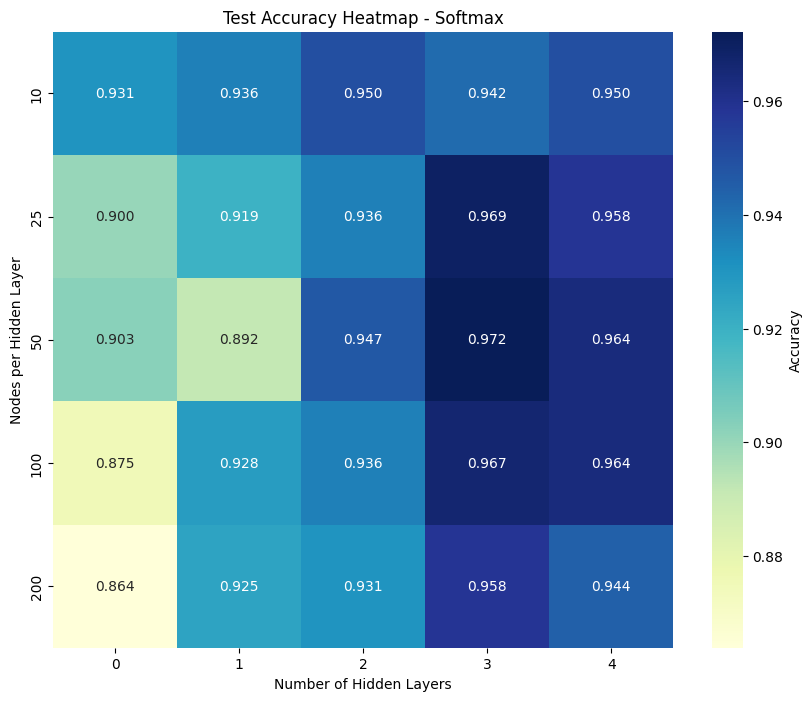

In [ ]:
# Store results in 2D array
results = np.zeros((len(num_hidden_layers), len(layer_sizes)))

for i, num_layers in enumerate(num_hidden_layers):
    for j, layer_size in enumerate(layer_sizes):

        if num_layers == 0:
            # No hidden layers - just input to output
            layer_output_sizes = [10]
            activation_funcs = [softmax]
        else:
            # Hidden layers + output layer
            layer_output_sizes = [layer_size] * num_layers + [10]
            activation_funcs = [softmax] * num_layers + [softmax]


        # Create and train network
        NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

        train_network_stocastic_ADAM(NN, X_train, y_train_onehot, eta=0.01, epochs=25)
        
        y_pred = NN.predict(X_test)
        acc = accuracy(y_pred, y_test_onehot)

        results[i, j] = acc

        print(f"Done with: {num_layers} x {layer_size}")

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=num_hidden_layers,
            yticklabels=layer_sizes,
            cbar_kws={'label': 'Accuracy'})
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Nodes per Hidden Layer')
plt.title('Test Accuracy Heatmap - Softmax')
plt.show()